In [28]:
# Data manipulation
import numpy as np
import pandas as pd
from math import *
import seaborn as sns
import networkx as nx
import os
#import osmnx as ox
#import folium

# Visualization.
import matplotlib.pyplot as plt

# Saving models
from datetime import datetime
import joblib

# Display all columns
pd.set_option('display.max_columns', 150,
             'display.max_rows', 150)

# ML
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedKFold, train_test_split, cross_validate, cross_val_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, median_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor


import requests, json
from sqlalchemy import create_engine

In [29]:
path0 = os.getcwd()

In [30]:
full = pd.read_csv(os.path.join(path0, "full_new.csv"))

In [31]:
full.columns

Index(['Unnamed: 0', 'order_id', 'lat_destination', 'lng_destination',
       'promised_time', 'on_demand', 'shopper_id', 'store_branch_id',
       'total_minutes', 'quantity_UN', 'quantity_KG', 'is_more_UN',
       'UN_plus_KG', 'UN_mult_KG', 'seniority', 'found_rate', 'picking_speed',
       'accepted_rate', 'rating', 'store_id', 'lat_origin', 'lng_origin',
       'Hour', 'Month', 'Day_of_Week', 'Year', 'Date', 'period',
       'distance_havesine', 'distance_car', 'weight_car', 'duration',
       'city_origin', 'state_origin', 'county_origin', 'neighbourhood_origin',
       'city_destiny', 'state_destiny', 'county_destiny',
       'neighbourhood_destiny', 'same_city', 'same_state', 'same_county',
       'same_neighbourhood', 'path_city', 'path_state', 'path_county',
       'shoppers_number', 'store_branch_number'],
      dtype='object')

In [32]:
var_cat = ['on_demand', 'seniority', 'Hour', 'Day_of_Week', 'period',
           'county_origin', 'county_destiny', 'state_origin', 'state_destiny',
           'city_origin', 'city_destiny',
           'path_city',
           'path_state', 
           'path_county',
           #'store_branch_id',
           #'shopper_id',
           'same_city', 'same_state', 'same_county',
           'same_neighbourhood'
          ]

var_num = ['quantity_UN', 'quantity_KG', 'UN_plus_KG', 'UN_mult_KG',
           'distance_havesine',
           'found_rate', 'picking_speed','accepted_rate', 'rating',
           'distance_car', 
           'weight_car', 
           'duration',
           'shoppers_number',
           'store_branch_number'
          ]

In [33]:
dft = pd.get_dummies(full[var_cat], columns= var_cat, drop_first=True)
cat_var = dft.columns

In [34]:
full = pd.get_dummies(full, columns = var_cat)

In [35]:
target = ['total_minutes']
full = full[list(cat_var)+list(var_num) + target]

### Out of Sample

In [36]:
ofs = full[full.total_minutes.isnull()]

In [37]:
ofs.head(3)

,on_demand_True,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,Hour_1,Hour_2,Hour_3,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Day_of_Week_5,Day_of_Week_6,period_dawn,period_morning,period_night,county_origin_Provincia de Concepción,county_origin_Provincia de Cordillera,county_origin_Provincia de Elqui,county_origin_Provincia de Maipo,county_origin_Provincia de Santiago,county_origin_Provincia de Valparaíso,county_destiny_Provincia de Concepción,county_destiny_Provincia de Cordillera,county_destiny_Provincia de Elqui,county_destiny_Provincia de Maipo,county_destiny_Provincia de Santiago,county_destiny_Provincia de Valparaíso,state_origin_Región de Coquimbo,state_origin_Región de Valparaíso,state_origin_Región del Biobío,state_destiny_Región de Coquimbo,state_destiny_Región de Valparaíso,state_destiny_Región del Biobío,city_origin_Colina,city_origin_Concepción,city_origin_Conchalí,city_origin_Coquimbo,city_origin_Estación Central,city_origin_Huechuraba,city_origin_Independencia,city_origin_La Florida,city_origin_La Serena,city_origin_Las Condes,city_origin_Lo Barnechea,city_origin_Macul,city_origin_Peñalolén,city_origin_Providencia,city_origin_Pudahuel,city_origin_Recoleta,city_origin_San Joaquín,city_origin_San Miguel,city_origin_San Pedro de la Paz,city_origin_Santiago,city_origin_Talcahuano,city_origin_Valparaíso,city_origin_Vitacura,city_origin_Viña del Mar,city_origin_undefined,city_origin_Ñuñoa,city_destiny_Cerro Navia,city_destiny_Colina,city_destiny_Concepción,city_destiny_Conchalí,city_destiny_Coquimbo,city_destiny_El Bosque,...,path_city_Valparaíso_X_Valparaíso,path_city_Valparaíso_X_Viña del Mar,path_city_Vitacura_X_Huechuraba,path_city_Vitacura_X_Las Condes,path_city_Vitacura_X_Lo Barnechea,path_city_Vitacura_X_Providencia,path_city_Vitacura_X_Recoleta,path_city_Vitacura_X_Santiago,path_city_Vitacura_X_Vitacura,path_city_Vitacura_X_undefined,path_city_Vitacura_X_Ñuñoa,path_city_Viña del Mar_X_Valparaíso,path_city_Viña del Mar_X_Viña del Mar,path_city_Viña del Mar_X_undefined,path_city_undefined_X_Cerrillos,path_city_undefined_X_Cerro Navia,path_city_undefined_X_Colina,path_city_undefined_X_Concepción,path_city_undefined_X_Conchalí,path_city_undefined_X_El Bosque,path_city_undefined_X_Estación Central,path_city_undefined_X_Huechuraba,path_city_undefined_X_La Florida,path_city_undefined_X_La Pintana,path_city_undefined_X_Las Condes,path_city_undefined_X_Peñalolén,path_city_undefined_X_Providencia,path_city_undefined_X_Pudahuel,path_city_undefined_X_Renca,path_city_undefined_X_San Pedro de la Paz,path_city_undefined_X_Santiago,path_city_undefined_X_Talcahuano,path_city_undefined_X_Vitacura,path_city_undefined_X_Viña del Mar,path_city_undefined_X_undefined,path_city_undefined_X_Ñuñoa,path_city_Ñuñoa_X_Las Condes,path_city_Ñuñoa_X_Peñalolén,path_city_Ñuñoa_X_Providencia,path_city_Ñuñoa_X_Santiago,path_city_Ñuñoa_X_undefined,path_city_Ñuñoa_X_Ñuñoa,path_state_Región de Coquimbo_X_Región de Coquimbo,path_state_Región de Valparaíso_X_Región de Valparaíso,path_state_Región del Biobío_X_Región del Biobío,path_county_Provincia de Chacabuco_X_Provincia de Santiago,path_county_Provincia de Concepción_X_Provincia de Concepción,path_county_Provincia de Cordillera_X_Provincia de Cordillera,path_county_Provincia de Cordillera_X_Provincia de Santiago,path_county_Provincia de Elqui_X_Provincia de Elqui,path_county_Provincia de Maipo_X_Provincia de Maipo,path_county_Provincia de Maipo_X_Provincia de Santiago,path_county_Provincia de Santiago_X_Provincia de Chacabuco,path_county_Provincia de Santiago_X_Provincia de Cordillera,path_county_Provincia de Santiago_X_Provincia de Maipo,path_county_Provincia de Santiago_X_Provincia de Santiago,path_county_Provincia de Valparaíso_X_Provincia de Valparaíso,same_city_1.0,same_county_1.0,same_neighbourhood_1.0,quantity_UN,quantity_KG,UN_plus_KG,UN_mult_KG,d

In [38]:
ofs.isnull().sum()

on_demand_True                                   0
seniority_50e13ee63f086c2fe84229348bc91b5b       0
seniority_6c90661e6d2c7579f5ce337c3391dbb9       0
seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f       0
Hour_1                                           0
                                              ... 
weight_car                                       0
duration                                         0
shoppers_number                                  0
store_branch_number                              0
total_minutes                                 1995
Length: 268, dtype: int64

### Modeling data

In [39]:
modeling = full[~full.total_minutes.isnull()]

In [40]:
modeling.head(3)

,on_demand_True,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,Hour_1,Hour_2,Hour_3,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Day_of_Week_5,Day_of_Week_6,period_dawn,period_morning,period_night,county_origin_Provincia de Concepción,county_origin_Provincia de Cordillera,county_origin_Provincia de Elqui,county_origin_Provincia de Maipo,county_origin_Provincia de Santiago,county_origin_Provincia de Valparaíso,county_destiny_Provincia de Concepción,county_destiny_Provincia de Cordillera,county_destiny_Provincia de Elqui,county_destiny_Provincia de Maipo,county_destiny_Provincia de Santiago,county_destiny_Provincia de Valparaíso,state_origin_Región de Coquimbo,state_origin_Región de Valparaíso,state_origin_Región del Biobío,state_destiny_Región de Coquimbo,state_destiny_Región de Valparaíso,state_destiny_Región del Biobío,city_origin_Colina,city_origin_Concepción,city_origin_Conchalí,city_origin_Coquimbo,city_origin_Estación Central,city_origin_Huechuraba,city_origin_Independencia,city_origin_La Florida,city_origin_La Serena,city_origin_Las Condes,city_origin_Lo Barnechea,city_origin_Macul,city_origin_Peñalolén,city_origin_Providencia,city_origin_Pudahuel,city_origin_Recoleta,city_origin_San Joaquín,city_origin_San Miguel,city_origin_San Pedro de la Paz,city_origin_Santiago,city_origin_Talcahuano,city_origin_Valparaíso,city_origin_Vitacura,city_origin_Viña del Mar,city_origin_undefined,city_origin_Ñuñoa,city_destiny_Cerro Navia,city_destiny_Colina,city_destiny_Concepción,city_destiny_Conchalí,city_destiny_Coquimbo,city_destiny_El Bosque,...,path_city_Valparaíso_X_Valparaíso,path_city_Valparaíso_X_Viña del Mar,path_city_Vitacura_X_Huechuraba,path_city_Vitacura_X_Las Condes,path_city_Vitacura_X_Lo Barnechea,path_city_Vitacura_X_Providencia,path_city_Vitacura_X_Recoleta,path_city_Vitacura_X_Santiago,path_city_Vitacura_X_Vitacura,path_city_Vitacura_X_undefined,path_city_Vitacura_X_Ñuñoa,path_city_Viña del Mar_X_Valparaíso,path_city_Viña del Mar_X_Viña del Mar,path_city_Viña del Mar_X_undefined,path_city_undefined_X_Cerrillos,path_city_undefined_X_Cerro Navia,path_city_undefined_X_Colina,path_city_undefined_X_Concepción,path_city_undefined_X_Conchalí,path_city_undefined_X_El Bosque,path_city_undefined_X_Estación Central,path_city_undefined_X_Huechuraba,path_city_undefined_X_La Florida,path_city_undefined_X_La Pintana,path_city_undefined_X_Las Condes,path_city_undefined_X_Peñalolén,path_city_undefined_X_Providencia,path_city_undefined_X_Pudahuel,path_city_undefined_X_Renca,path_city_undefined_X_San Pedro de la Paz,path_city_undefined_X_Santiago,path_city_undefined_X_Talcahuano,path_city_undefined_X_Vitacura,path_city_undefined_X_Viña del Mar,path_city_undefined_X_undefined,path_city_undefined_X_Ñuñoa,path_city_Ñuñoa_X_Las Condes,path_city_Ñuñoa_X_Peñalolén,path_city_Ñuñoa_X_Providencia,path_city_Ñuñoa_X_Santiago,path_city_Ñuñoa_X_undefined,path_city_Ñuñoa_X_Ñuñoa,path_state_Región de Coquimbo_X_Región de Coquimbo,path_state_Región de Valparaíso_X_Región de Valparaíso,path_state_Región del Biobío_X_Región del Biobío,path_county_Provincia de Chacabuco_X_Provincia de Santiago,path_county_Provincia de Concepción_X_Provincia de Concepción,path_county_Provincia de Cordillera_X_Provincia de Cordillera,path_county_Provincia de Cordillera_X_Provincia de Santiago,path_county_Provincia de Elqui_X_Provincia de Elqui,path_county_Provincia de Maipo_X_Provincia de Maipo,path_county_Provincia de Maipo_X_Provincia de Santiago,path_county_Provincia de Santiago_X_Provincia de Chacabuco,path_county_Provincia de Santiago_X_Provincia de Cordillera,path_county_Provincia de Santiago_X_Provincia de Maipo,path_county_Provincia de Santiago_X_Provincia de Santiago,path_county_Provincia de Valparaíso_X_Provincia de Valparaíso,same_city_1.0,same_county_1.0,same_neighbourhood_1.0,quantity_UN,quantity_KG,UN_plus_KG,UN_mult_KG,d

In [41]:
modeling.isnull().sum()

on_demand_True                                0
seniority_50e13ee63f086c2fe84229348bc91b5b    0
seniority_6c90661e6d2c7579f5ce337c3391dbb9    0
seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f    0
Hour_1                                        0
                                             ..
weight_car                                    0
duration                                      0
shoppers_number                               0
store_branch_number                           0
total_minutes                                 0
Length: 268, dtype: int64

In [42]:
# Getting the data:
X = modeling.drop(['total_minutes'], axis = 1)

y = modeling['total_minutes']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 451, test_size= .25)

In [44]:
StdSca = StandardScaler() ## or standerscaler 
X_train[var_num] = pd.DataFrame(StdSca.fit_transform(X_train[var_num]), columns = var_num, index = X_train.index)
X_test[var_num] = pd.DataFrame(StdSca.transform(X_test[var_num]), columns = var_num, index = X_test.index)

C:\Users\aureliano.paiva_tc\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\aureliano.paiva_tc\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [45]:
ofs[var_num] = StdSca.transform(ofs[var_num])

C:\Users\aureliano.paiva_tc\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [46]:
#list(X_train.columns)

## Model

CV = cross_validate(estimator = RandomForestRegressor(n_estimators = 50, 
                    min_samples_split = 20, min_samples_leaf= 10, max_depth = 6, random_state=42), 
                    cv = 5, 
                    #scoring = "r2", 
                    scoring = ["r2", 'neg_median_absolute_error', 'max_error', 'neg_mean_squared_error',  'neg_mean_absolute_percentage_error'], 
                    X = X_train,
                    y = y_train)

cv_df = pd.DataFrame(CV)
cv_df

In [47]:
CV = cross_validate(estimator = ElasticNet(alpha=0.025, l1_ratio=0.5), 
                    cv = 5, 
                    scoring = ["r2", 'neg_median_absolute_error', 'max_error', 'neg_mean_squared_error',  'neg_mean_absolute_percentage_error'], 
                    return_estimator = True,
                    return_train_score= False,
                    X = X_train,
                    y = y_train)
cv_df = pd.DataFrame(CV)
cv_df

,fit_time,score_time,estimator,test_r2,test_neg_median_absolute_error,test_max_error,test_neg_mean_squared_error,test_neg_mean_absolute_percentage_error
0,0.289660,0.008120,ElasticNet(alpha=0.025),0.501447,-14.891466,-132.356840,-596.154250,-0.260492
1,0.187384,0.000000,ElasticNet(alpha=0.025),0.477596,-14.068026,-194.551561,-632.511721,-0.245431
2,0.215754,0.008007,ElasticNet(alpha=0.025),0.476306,-14.863238,-144.018668,-626.991822,-0.258347
3,0.239477,0.007996,ElasticNet(alpha=0.025),0.538330,-14.338929,-137.336851,-546.237595,-0.254243
4,0.232258,0.008308,ElasticNet(alpha=0.025),0.554112,-14.650934,-107.309595,-526.981344,-0.259162


In [48]:
y.describe()

count    7983.000000
mean       81.152277
std        34.705843
min        11.969489
25%        55.301119
50%        74.752992
75%       100.302939
max       304.190303
Name: total_minutes, dtype: float64

In [49]:
CV = CV["estimator"]

In [50]:
ofs = ofs.drop(['total_minutes'], axis = 1)

In [51]:
X_test['pred'] = CV[4].predict(X_test)

C:\Users\AURELI~1.PAI\AppData\Local\Temp/ipykernel_15068/1753647709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred'] = CV[4].predict(X_test)


In [52]:
X_test['targt'] = y_test

C:\Users\AURELI~1.PAI\AppData\Local\Temp/ipykernel_15068/3704014181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['targt'] = y_test


In [55]:
X_test['diff'] = abs(X_test['targt'] - X_test['pred'])

C:\Users\AURELI~1.PAI\AppData\Local\Temp/ipykernel_15068/1928622416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['diff'] = abs(X_test['targt'] - X_test['pred'])


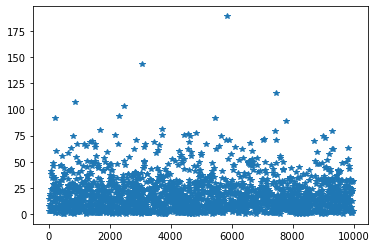

In [56]:
plt.plot(X_test['diff'],'*')
plt.show()

In [58]:
X_test['diff']

1907    59.365464
5243     7.565977
5861    30.562613
167     12.077609
9438    16.264533
          ...    
4592     4.136507
9555    40.879877
9950    22.236098
2976    24.739039
5215    27.547690
Name: diff, Length: 1996, dtype: float64

In [63]:
len(X_test[X_test['diff'] <= 25])/len(X_test)

0.7374749498997996